In [1]:
%config InlineBackend.figure_format = 'retina'

import utils
import pymc as pm
import aesara.tensor as at
import aesara
import arviz as az
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, auc
)

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])

# 16M1

In [2]:
df = pd.read_csv("data/howell1.csv", sep=";")

In [3]:
W = (df.weight / df.weight.mean()).values
H = (df.height / df.height.mean()).values

with pm.Model() as model_15m1:
    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Exponential("k", lam=0.25)
    p = pm.Beta("p", 2, 5)
    mu = at.log(np.pi * k * p**2 * H**3)
    pm.LogNormal("w", mu=mu, sigma=sigma, observed=W)

In [4]:
trace_15m1 = pm.sample(model=model_15m1)
posterior = pm.sample_posterior_predictive(trace_15m1, model=model_15m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
Sampling: [w]


In [5]:
with pm.Model() as model_15m1_2:
    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Exponential("k", lam=0.5)
    p = pm.Beta("p", 2, 18)
    exp = pm.Normal("exp", mu=3, sigma=1)
    mu = at.log(np.pi * k * p**2 * H**exp)
    pm.LogNormal("w", mu=mu, sigma=sigma, observed=W)

In [6]:
trace_15m1_2 = pm.sample(model=model_15m1_2)
posterior = pm.sample_posterior_predictive(trace_15m1_2, model=model_15m1_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p, exp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
The acceptance probability does not match the target. It is 0.8841, but should be close to 0.8. Try to increase the number of tuning steps.
Sampling: [w]


In [7]:
az.summary(trace_15m1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
exp,2.325,0.022,2.283,2.366,0.000,0.000,2242.0,2113.0,1.0
sigma,0.126,0.004,0.120,0.134,0.000,0.000,2263.0,2172.0,1.0
k,5.640,2.731,1.634,10.695,0.069,0.049,1451.0,1701.0,1.0
p,0.249,0.060,0.148,0.360,0.002,0.001,1452.0,1701.0,1.0


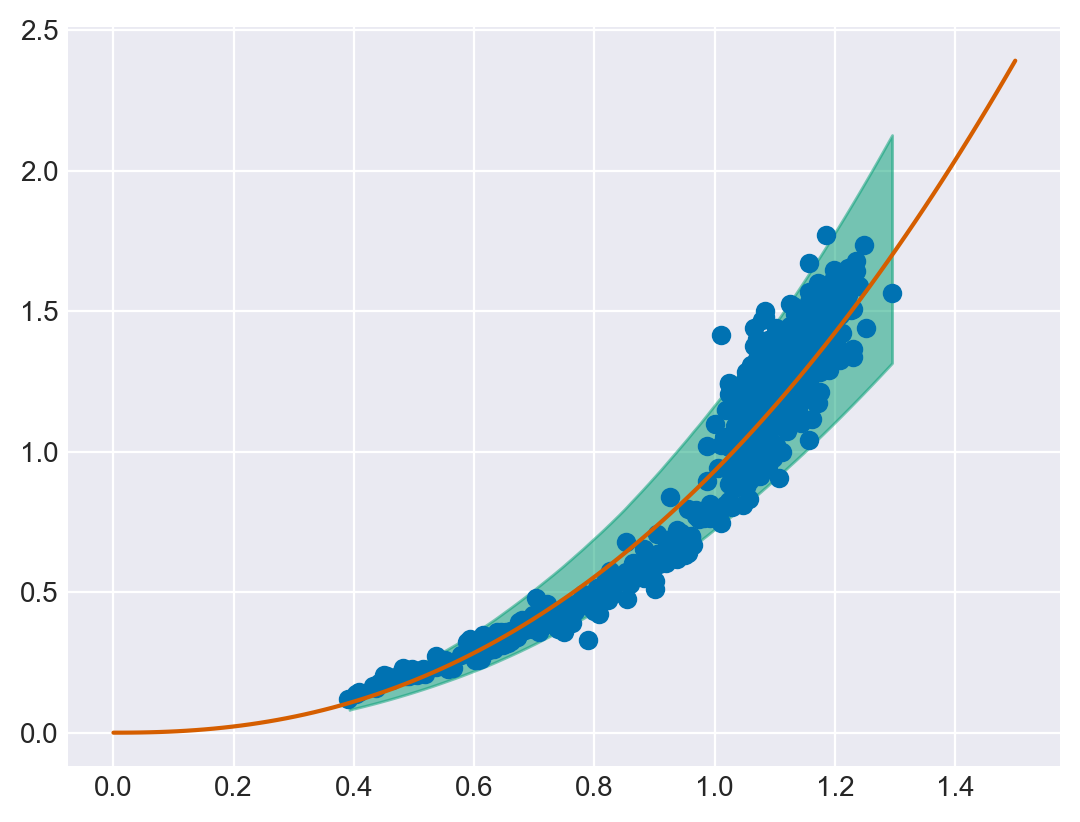

In [8]:
h_seq = np.linspace(0, 1.5, 100)
az.plot_hdi(H, posterior.posterior_predictive["w"])
plt.scatter(H, W)

def calc_mu(h):
    mu = np.pi * trace_15m1_2.posterior["k"] * trace_15m1_2.posterior["p"] ** 2 * h ** trace_15m1_2.posterior["exp"]
    return mu.mean()
mu_mean = [calc_mu(h) for h in h_seq]
plt.plot(h_seq, mu_mean, c="C02")

# Chimpanzee nut cracker model and prior predictive check

The data is better fitted. It might be overfitting a bit but is clearly better adjusted for kids and adults, not as good for mid age.

The value of sigma is narrower now, indicating there is less variance in the prediction.

In [9]:
df = pd.read_csv("data/Pandas_nuts.csv", sep=";")
df['sex'] = df.sex.astype("category")
df['chimpazee'] = df.chimpanzee.astype("category")

In [10]:
age = (df.age / df.age.max()).values
seconds = df.seconds.values

with pm.Model() as nuts:
    phi = pm.LogNormal("phi", np.log(1), 0.1)
    k = pm.LogNormal("k", np.log(2), 0.25)
    theta = pm.LogNormal("theta", np.log(5), 0.25)

    mu = seconds * phi * (1-at.exp(-k * age))**theta
    pm.Poisson("n", mu=mu, observed=df.nuts_opened)

In [11]:
with nuts:
    prior = pm.sample_prior_predictive(50)

Sampling: [k, n, phi, theta]


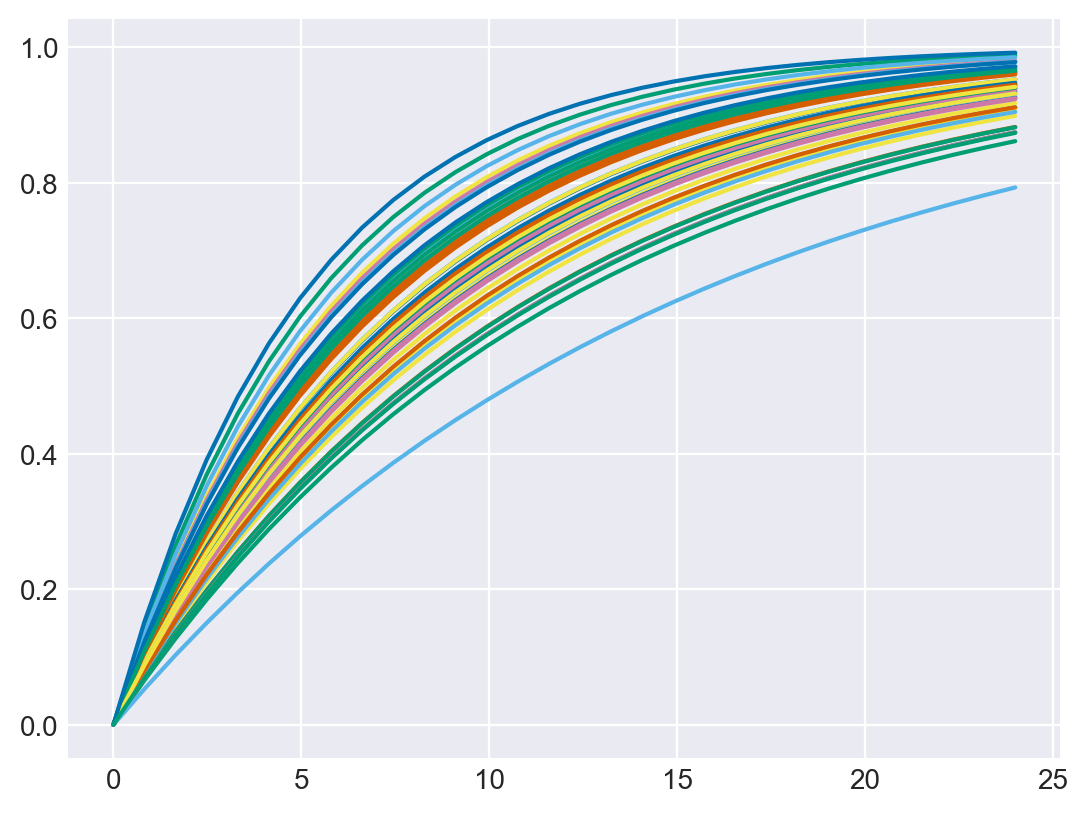

In [12]:
age_ppc = np.linspace(0, 24, 30)
for k in prior.prior["k"][0].values:
    m_ppc = 1-np.exp(-k * age_ppc/df.age.max())
    plt.plot(age_ppc, m_ppc)

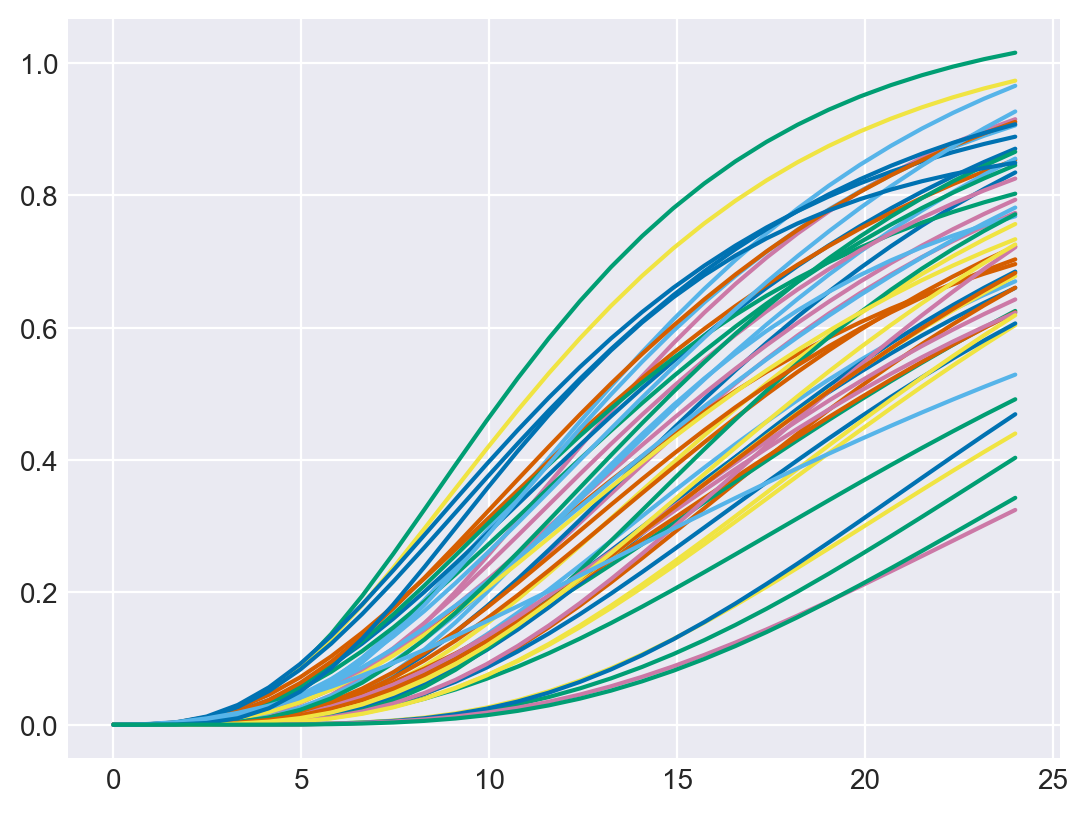

In [13]:
age_ppc = np.linspace(0, 24, 30)
for phi, k , theta in zip(prior.prior["phi"][0].values, prior.prior["k"][0].values, prior.prior["theta"][0].values):
    sec_ppc = phi * (1-np.exp(-k * age_ppc/df.age.max()))**theta
    plt.plot(age_ppc, sec_ppc)

# 16H1

Modify the Panda nut opening model so that male and female chinpazees have different maximum adult body mass. The sex variable in data panda nuts provides the information you need. Be sure to incorporate the fact that you know, prior to seeing the data, that males are on average larger than females at maturity.

In [25]:
is_female = 1-(df.sex.cat.codes).values

(0.0, 1.0)

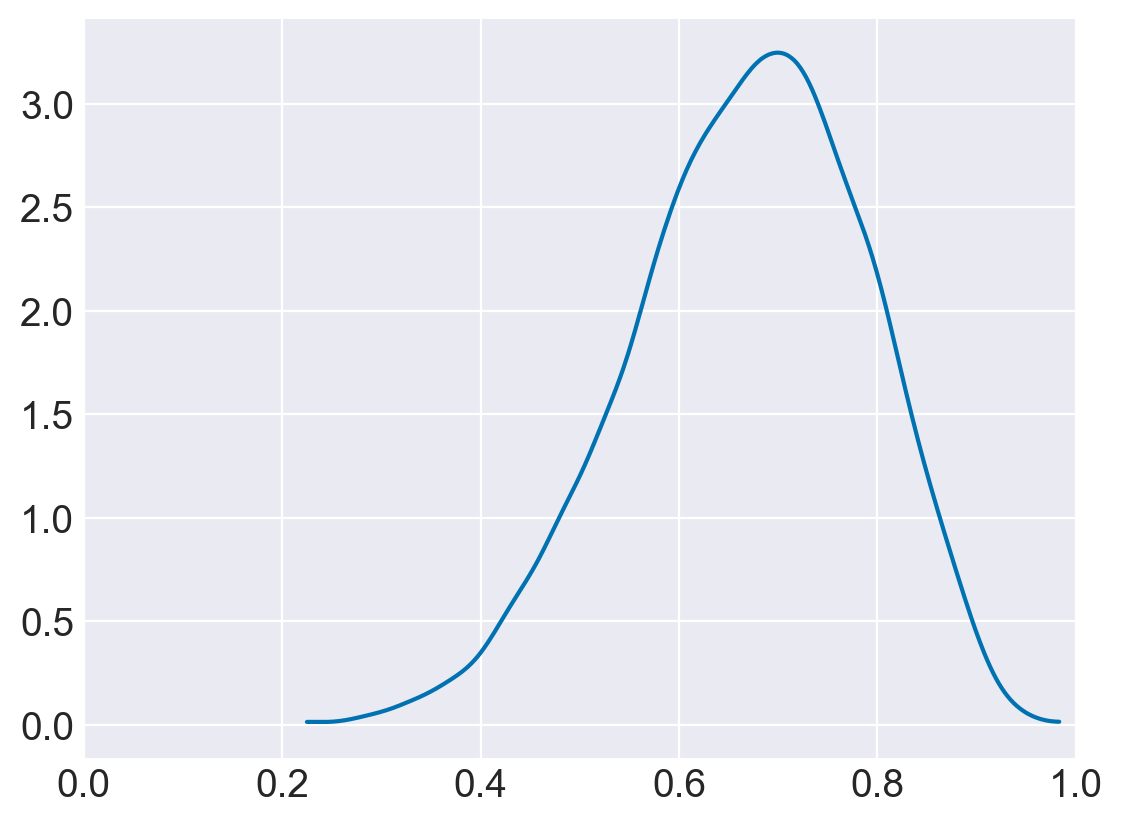

In [52]:
az.plot_dist(np.random.beta(10,5, size=10000))
plt.xlim(0, 1)

In [100]:
age = (df.age / df.age.max()).values
seconds = df.seconds.values

with pm.Model() as model_16h1:
    phi = pm.LogNormal("phi", np.log(1), 0.1)
    k = pm.LogNormal("k", np.log(2), 0.25)
    theta = pm.LogNormal("theta", np.log(5), 0.25)
    fem_penalty = pm.Beta("fem_penalty", alpha=10, beta=5)
    penalty = (is_female * fem_penalty + 1-is_female)

    mu = seconds * phi * penalty * (1-at.exp(-k * age))**theta
    pm.Poisson("n", mu=mu, observed=df.nuts_opened)

In [101]:
with model_16h1:
    prior = pm.sample_prior_predictive(50)

Sampling: [fem_penalty, k, n, phi, theta]


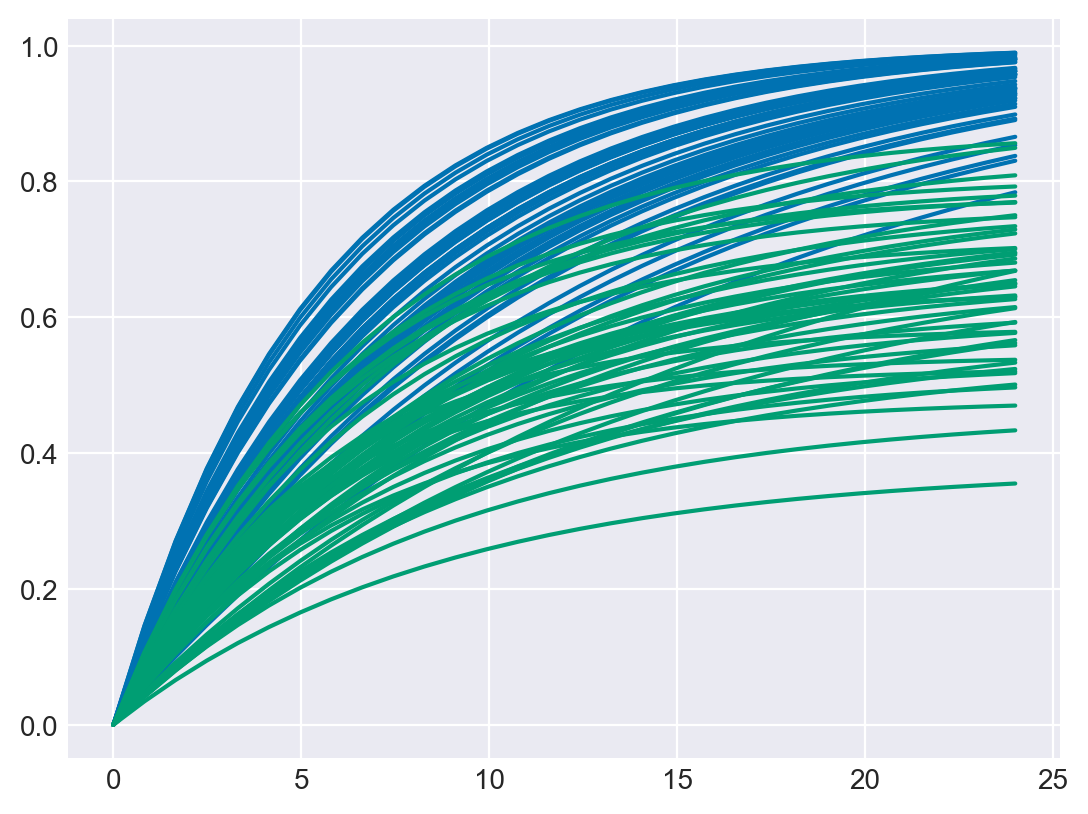

In [102]:
age_ppc = np.linspace(0, 24, 30)
for k, fem_penalty in zip(prior.prior["k"][0].values, prior.prior["fem_penalty"][0].values):
    is_female = 0
    penalty = (is_female * fem_penalty + 1-is_female)
    m_ppc = penalty * (1-np.exp(-k * age_ppc/df.age.max()))
    plt.plot(age_ppc, m_ppc, c="C00")

age_ppc = np.linspace(0, 24, 30)
for k, fem_penalty in zip(prior.prior["k"][0].values, prior.prior["fem_penalty"][0].values):
    is_female = 1
    penalty = (is_female * fem_penalty + 1-is_female)
    m_ppc = penalty * (1-np.exp(-k * age_ppc/df.age.max()))
    plt.plot(age_ppc, m_ppc, c="C01")

In [103]:
with model_16h1:
    posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, k, theta, fem_penalty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8805, but should be close to 0.8. Try to increase the number of tuning steps.


In [104]:
az.summary(posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,1.062,0.083,0.898,1.208,0.002,0.001,1976.0,2150.0,1.0
k,6.301,0.570,5.242,7.375,0.015,0.011,1428.0,1429.0,1.0
theta,10.594,2.179,6.702,14.599,0.058,0.041,1402.0,1425.0,1.0
fem_penalty,0.779,0.062,0.659,0.891,0.002,0.001,1723.0,1341.0,1.0


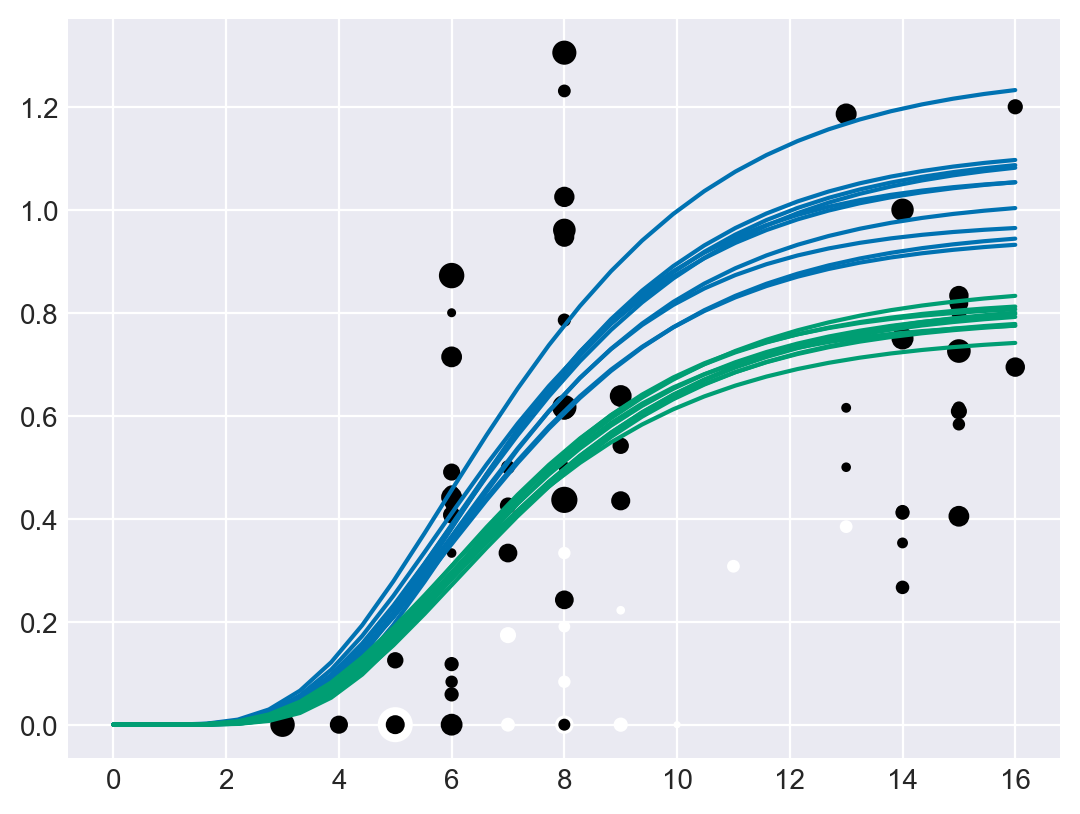

In [105]:
age_ppc = np.linspace(0, 16, 30)
for phi, k , theta, fem_penalty in zip(posterior.posterior["phi"][0].values[:10], posterior.posterior["k"][0].values[:10],
                          posterior.posterior["theta"][0].values[:10], posterior.posterior["fem_penalty"][0].values[:10]):
    is_female = 0
    penalty = is_female*fem_penalty + 1-is_female
    sec_ppc = phi * penalty * (1-np.exp(-k * age_ppc/df.age.max()))**theta
    plt.plot(age_ppc, sec_ppc, c="C00")

age_ppc = np.linspace(0, 16, 30)
for phi, k , theta, fem_penalty in zip(posterior.posterior["phi"][0].values[:10], posterior.posterior["k"][0].values[:10],
                          posterior.posterior["theta"][0].values[:10], posterior.posterior["fem_penalty"][0].values[:10]):
    is_female = 1
    penalty = is_female*fem_penalty + 1-is_female
    sec_ppc = phi * penalty * (1-np.exp(-k * age_ppc/df.age.max()))**theta
    plt.plot(age_ppc, sec_ppc, c="C01")

plt.scatter(df.age, df.nuts_opened / df.seconds, s=df.seconds, c=df.sex.cat.codes)

# 16H2

Now return to the Panda nut model and try to incorporate individual differences. There are two parameters, phi and kappa, which plausibly vary by individual. Pick on of these, allow it to vary by individual, and use partial pooling to avoid overfitting. The variable chipanzee in the data panda nuts tells you observations belong to which individual.

In [134]:
age = (df.age / df.age.max()).values
seconds = df.seconds.values
chimpanzee = df.chimpanzee.astype("category")
coords = {
    "chimpanzee": chimpanzee.cat.categories
}

with pm.Model(coords=coords) as model_16h2:
    phi = pm.LogNormal("phi", np.log(1), 0.1)

    k_population = pm.LogNormal("k_population", np.log(2), 0.25)
    k = pm.LogNormal("k", k_population, 0.25, dims="chimpanzee")

    theta = pm.LogNormal("theta", np.log(5), 0.25)
    fem_penalty = pm.Beta("fem_penalty", alpha=10, beta=5)
    penalty = (is_female * fem_penalty + 1-is_female)

    mu = seconds * phi * penalty * (1-at.exp(-k[chimpanzee.cat.codes] * age))**theta
    pm.Poisson("n", mu=mu, observed=df.nuts_opened)

In [135]:
with model_16h2:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, k_population, k, theta, fem_penalty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

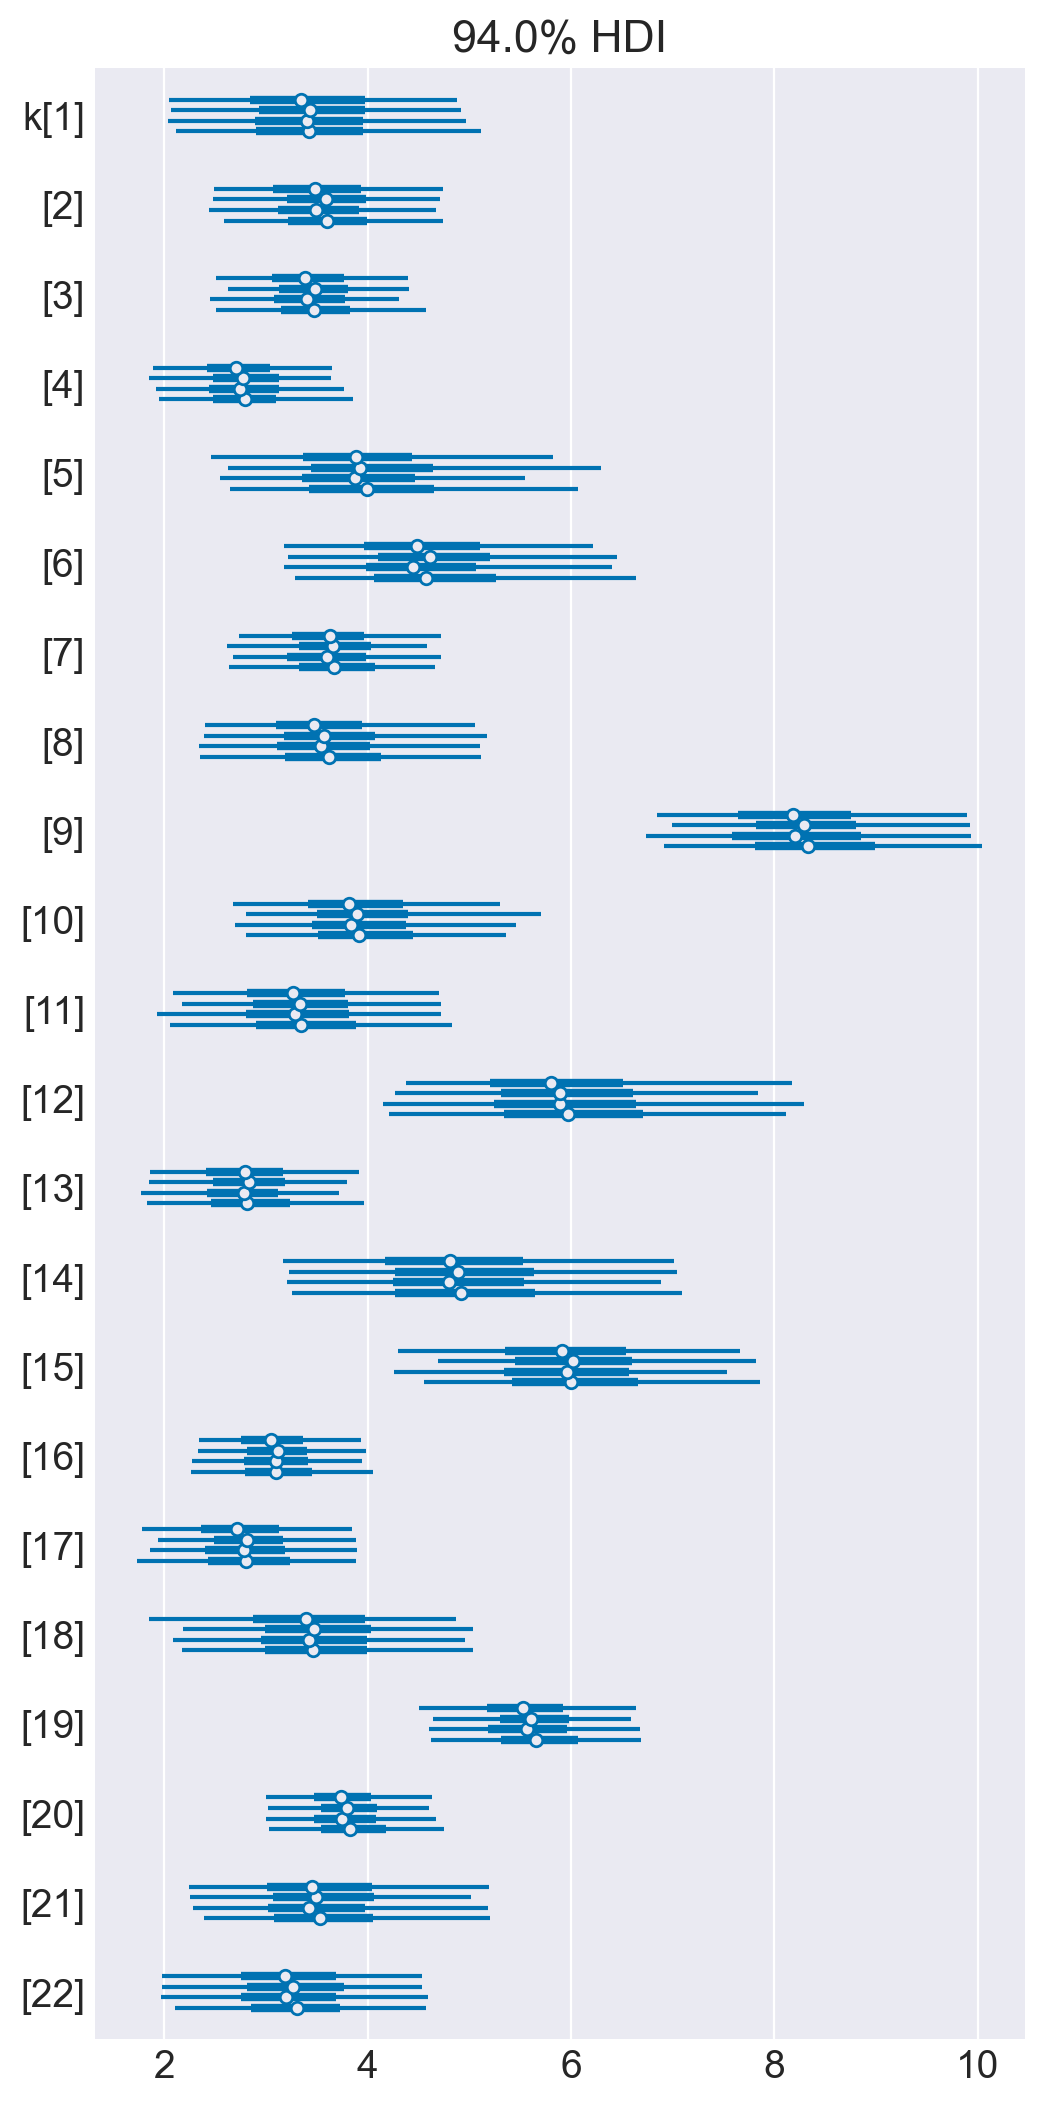

In [138]:
az.plot_forest(trace, var_names="k")